In [1]:
!pip install -q kaggle


In [2]:
!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/


In [3]:
# change the permisions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
 # test it out
 !kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57          11179        236  1.0              
owm4096/laptop-prices                                            Laptop Prices                                        25KB  2024-09-09 12:43:01           2559         45  1.0              
abdullah0a/student-dropout-analysis-and-prediction-dataset       Student Dropout Analysis and Prediction Dataset      11KB  2024-09-18 09:32:30           1193         27  1.0              
samuelotiattakorah/lung-cancer-data                    

In [5]:
%mkdir dataset
%mkdir dataset/images # for source images
%mkdir dataset/masks # for annotation masks
%mkdir dataset/test # for test images
%mkdir dataset/temp # temp storage


In [25]:
# start the download
!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100% 9.57G/9.58G [05:45<00:00, 26.5MB/s]
100% 9.58G/9.58G [05:45<00:00, 29.7MB/s]


In [26]:
!unzip chest-xray-masks-and-labels.zip -d dataset/temp/


Archive:  chest-xray-masks-and-labels.zip
  inflating: dataset/temp/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
 

In [27]:
%ls dataset/temp/Lung\ Segmentation

ClinicalReadings/  masks/                       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png/           NLM-ChinaCXRSet-ReadMe.docx  test/


In [28]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"

In [29]:
%mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'

In [30]:
%mv dataset/temp/Lung\ Segmentation/test/* dataset/test/
TEST_PATH = '/content/dataset/test/'

In [31]:
# remove the original zip file
%rm chest-xray-masks-and-labels.zip

In [32]:
# clean-up
%rm -r dataset/temp/

In [33]:
#HARMONIZE THE DATASET

In [34]:
# importing os module
import os

# suffix cropping function
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

suffix = "_mask.png"

# iterate over all mask images and edit the file-names
for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  res = rchop(src, suffix)
  dst = ""
  if src != res:
    dst = rchop(src, suffix) + ".png"
    os.rename(src, dst)

In [35]:
# check the number of files in the images/ and masks/ directories
import os.path

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))


number of files in images/ directory: 800
number of files in masks/ directory: 704


In [36]:
# function to confirm the existence of a file in a given directory
def searchFile(fileName, TARGET_PATH):
  for root, dirs, files in os.walk(TARGET_PATH):
    for Files in files:
      #print(Files)
      found = Files.find(fileName)
      if found != -1:
        break
  return found

In [37]:
%mkdir /content/dataset/orphan_images

mkdir: cannot create directory ‘/content/dataset/orphan_images’: File exists


In [38]:
# clean up the images/ directory by removing all images that do not have a mask
import shutil

cnt = 0

for count, filename in enumerate(os.listdir("/content/dataset/images")):
  found = searchFile(filename, MASK_PATH)
  if found == -1:
    cnt = cnt + 1
    src = "/content/dataset/images/" + filename
    dst = "/content/dataset/orphan_images/" + filename
    dest = shutil.move(src, dst)
print("number of files not matched: " + str(cnt))

number of files not matched: 96


In [39]:
# confirm consistency
print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

number of files in images/ directory: 704
number of files in masks/ directory: 704


In [40]:
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf

# Path to images and masks directories
IMAGE_PATH = "/content/dataset/images"
MASK_PATH = "/content/dataset/masks"

# Function to load images and masks
def load_data(split=0.1):
    images = sorted(glob(os.path.join(IMAGE_PATH, "*.png")))
    masks = sorted(glob(os.path.join(MASK_PATH, "*.png")))

    # Ensure same number of images and masks
    assert len(images) == len(masks), "Number of images and masks do not match"

    # Pair images with corresponding masks
    data = list(zip(images, masks))

    # Split into training and validation sets
    train_data, valid_data = train_test_split(data, test_size=split, random_state=42)

    train_x, train_y = zip(*train_data)
    valid_x, valid_y = zip(*valid_data)

    return (list(train_x), list(train_y)), (list(valid_x), list(valid_y))


def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512, 512))  # Resize image to match input shape of U-Net model
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512, 512))  # Resize mask to match input shape of U-Net model
    x = x / 255.0  # Normalize mask to [0, 1]
    x = np.expand_dims(x, axis=-1)  # Expand dimensions to match U-Net's expected input shape
    return x


# def read_mask(path):
#     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     x = cv2.resize(x, (512, 512))  # Resize mask to match input shape of U-Net model
#     x = x / 255  # Normalize mask
#     x = x.astype(np.float32)
#     x = np.expand_dims(x, axis=-1)  # Expand dimensions to match U-Net's expected input shape
#     return x


def tf_parse(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.numpy().decode()  # Convert to NumPy array and decode
        mask_path = mask_path.numpy().decode()  # Convert to NumPy array and decode

        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = tf.image.resize(image, [512, 512])

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, dtype=tf.float32)
        mask = tf.image.resize(mask, [512, 512])

        return image, mask

    image, mask = tf.py_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([512, 512, 3])
    mask.set_shape([512, 512, 1])
    return image, mask


def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.map(augment)  # Add this line
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset


# def tf_dataset(X, Y, batch=8):
#     dataset = tf.data.Dataset.from_tensor_slices((X, Y))
#     dataset = dataset.shuffle(buffer_size=200)
#     dataset = dataset.map(tf_parse)
#     dataset = dataset.batch(batch)
#     dataset = dataset.prefetch(4)
#     return dataset
# def tf_parse(x, y):
#     def _parse(x, y):
#         x = x.decode()
#         y = y.decode()

#         x = read_image(x)
#         y = read_mask(y)
#         return x, y

#     x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
#     x.set_shape([512, 512, 3])
#     y.set_shape([512, 512, 1])
#     return x, y

# def tf_dataset(X, Y, batch=8):
#     dataset = tf.data.Dataset.from_tensor_slices((X, Y))
#     dataset = dataset.shuffle(buffer_size=200)
#     dataset = dataset.map(tf_parse)
#     dataset = dataset.batch(batch)
#     dataset = dataset.prefetch(4)
#     return dataset


**BUILDING THE UNET MODEL**

In [41]:
#UNET MODEL

#final Result of old model:
# Epoch 9/10
# 80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9810 - loss: 0.0643 - val_accuracy: 0.9765 - val_loss: 0.0723
# Epoch 10/10
# 80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9818 - loss: 0.0610 - val_accuracy: 0.9661 - val_loss: 0.1061

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):  #Takes the previous feature map and builds the segmentation mask
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #bridge between the encoderblock and the decoder block

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


**TRAINING THE MODEL**

In [42]:
#seperately for test images
def load_test_data():
    test_images = sorted(glob("/content/dataset/test/*.png"))
    return test_images

In [43]:
#For the OLD MODEL:
from tensorflow.keras.optimizers import Adam

(train_x, train_y), (valid_x, valid_y) = load_data()
test_x = load_test_data()

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)}")

# Create TensorFlow datasets
train_dataset = tf_dataset(train_x, train_y, batch=8)
valid_dataset = tf_dataset(valid_x, valid_y, batch=8)

# Build U-Net model
input_shape = (512, 512, 3)
model = build_unet(input_shape)

def dice_loss(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return 1 - (2 * intersection + smooth) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=['accuracy', dice_coefficient])

# # Compile the model with metrics
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


Train: 633 - 633
Valid: 71 - 71
Test: 96


In [44]:
#MODEL compilation:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Recompile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

print("Model recompiled.")

Model recompiled.


**FOR TESTING:**

In [45]:
#FOR testing Only:
# import tensorflow as tf

# @tf.function
# def train_step(images, masks):
#     with tf.GradientTape() as tape:
#         predictions = model(images, training=True)
#         loss = model.loss(masks, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return loss

# def custom_fit(train_dataset, epochs=3):
#     for epoch in range(epochs):
#         print(f"Epoch {epoch + 1}/{epochs}")
#         for step, (images, masks) in enumerate(train_dataset):
#             loss = train_step(images, masks)
#             if step % 10 == 0:
#                 print(f"Step {step}, Loss: {loss.numpy():.4f}")
#         print(f"Epoch {epoch + 1} completed.")

# try:
#     custom_fit(train_dataset)
#     print("Custom training completed successfully.")
# except Exception as e:
#     print(f"Error during custom training: {str(e)}")

In [46]:
def check_dataset(dataset, name):
    print(f"Checking {name} dataset:")
    try:
        for images, masks in dataset.take(1):
            print(f"  Shape of images batch: {images.shape}")
            print(f"  Shape of masks batch: {masks.shape}")
            print(f"  Data type of images: {images.dtype}")
            print(f"  Data type of masks: {masks.dtype}")
            print(f"  Range of values in images: [{tf.reduce_min(images).numpy()}, {tf.reduce_max(images).numpy()}]")
            print(f"  Range of values in masks: [{tf.reduce_min(masks).numpy()}, {tf.reduce_max(masks).numpy()}]")
        print(f"{name} dataset seems to be correctly formatted.")
    except Exception as e:
        print(f"Error in {name} dataset: {str(e)}")

# Use this function to check your datasets
check_dataset(train_dataset, "Training")
check_dataset(valid_dataset, "Validation")

Checking Training dataset:
  Shape of images batch: (8, 512, 512, 3)
  Shape of masks batch: (8, 512, 512, 1)
  Data type of images: <dtype: 'float32'>
  Data type of masks: <dtype: 'float32'>
  Range of values in images: [0.0, 1.0]
  Range of values in masks: [0.0, 1.0]
Training dataset seems to be correctly formatted.
Checking Validation dataset:
  Shape of images batch: (8, 512, 512, 3)
  Shape of masks batch: (8, 512, 512, 1)
  Data type of images: <dtype: 'float32'>
  Data type of masks: <dtype: 'float32'>
  Range of values in images: [0.0, 1.0]
  Range of values in masks: [0.0, 1.0]
Validation dataset seems to be correctly formatted.


In [47]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



def dice_loss(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return 1 - (2 * intersection + smooth) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Recompile the model with the new loss function
model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=25,  # Run test with Increased epochs
    callbacks=[early_stopping]
)
#Dont run this...
# After training, load the best model
#model = tf.keras.models.load_model('best_model.h5', custom_objects={'bce_dice_loss': bce_dice_loss})


Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.7524 - loss: 0.9269 - val_accuracy: 0.7392 - val_loss: 1.2857
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9689 - loss: 0.3002 - val_accuracy: 0.7393 - val_loss: 1.3983
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9755 - loss: 0.2420 - val_accuracy: 0.7386 - val_loss: 1.4988
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9727 - loss: 0.2320 - val_accuracy: 0.7392 - val_loss: 1.7065
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9793 - loss: 0.1873 - val_accuracy: 0.7978 - val_loss: 1.2141
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.9785 - loss: 0.1817 - val_accuracy: 0.8711 - val_loss: 0.7280
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9798 - loss: 0.1653 - val_accuracy: 0.8653 - val_loss: 0.7801
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9797 - loss: 0.1560 - val_accuracy: 0.9653 - v


**Model metrics by epoch 10:**

accuracy: 0.9812 - loss: 0.1271 - val_accuracy: 0.9792 - val_loss: 0.1343

**Model By EPOCH 25**

80/80 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9809 - loss: 0.1069 - val_accuracy: 0.9800 - val_loss: 0.1107

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


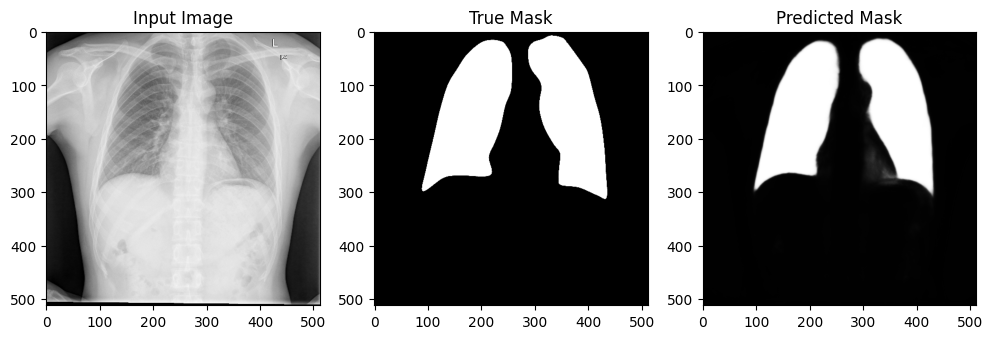

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image shape: (8, 512, 512, 3)
Mask shape: (8, 512, 512, 1)
Prediction shape: (8, 512, 512, 1)
Image data type: <dtype: 'float32'>
Mask data type: <dtype: 'float32'>
Prediction data type: float32
Image value range: [0.0, 1.0]
Mask value range: [0.0, 1.0]
Prediction value range: [0.00014346916577778757, 0.9999994039535522]


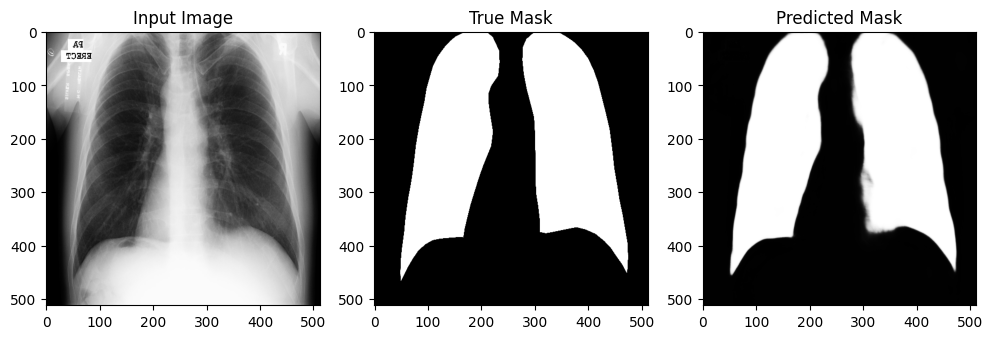

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Image shape: (8, 512, 512, 3)
Mask shape: (8, 512, 512, 1)
Prediction shape: (8, 512, 512, 1)
Image data type: <dtype: 'float32'>
Mask data type: <dtype: 'float32'>
Prediction data type: float32
Image value range: [0.0, 1.0]
Mask value range: [0.0, 1.0]
Prediction value range: [0.0001748828508425504, 0.999998927116394]


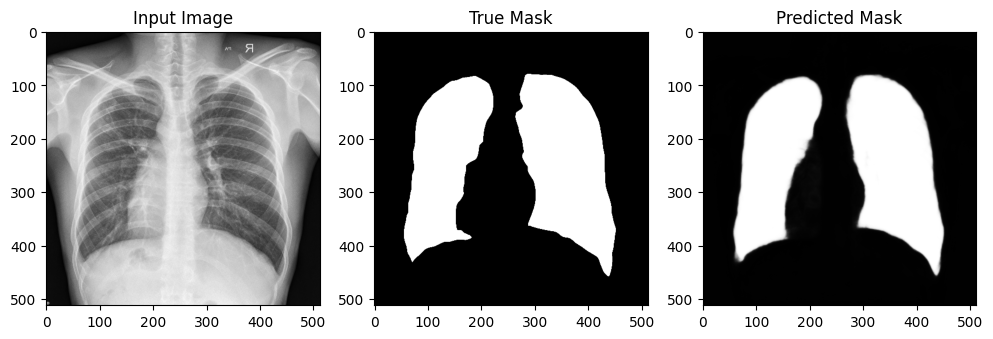

In [51]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_prediction(image, mask, prediction):
    plt.figure(figsize=(12, 4))

    # Convert tensors to numpy arrays and remove extra dimensions
    image = tf.squeeze(image).numpy()
    mask = tf.squeeze(mask).numpy()
    prediction = tf.squeeze(prediction).numpy()

    plt.subplot(131)
    plt.imshow(image)
    plt.title('Input Image')

    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask')

    plt.subplot(133)
    plt.imshow(prediction, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

for image, mask in valid_dataset.take(1):
    prediction = model.predict(image)
    visualize_prediction(image[0], mask[0], prediction[0])

# After training
for image, mask in valid_dataset.take(2):
    prediction = model.predict(image)

    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Prediction shape: {prediction.shape}")

    print(f"Image data type: {image.dtype}")
    print(f"Mask data type: {mask.dtype}")
    print(f"Prediction data type: {prediction.dtype}")

    print(f"Image value range: [{tf.reduce_min(image).numpy()}, {tf.reduce_max(image).numpy()}]")
    print(f"Mask value range: [{tf.reduce_min(mask).numpy()}, {tf.reduce_max(mask).numpy()}]")
    print(f"Prediction value range: [{tf.reduce_min(prediction).numpy()}, {tf.reduce_max(prediction).numpy()}]")

    visualize_prediction(image[0], mask[0], prediction[0])

In [52]:
#save model:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/FinalUnetValidated.h5')

Mounted at /content/drive


If overfitting, Actions to take:

1.   Add a dropout layer to the Unet architecture
2.   add an L1 or L2 layer regularization to do the same
3.   Add Data augmentation [A method to increasy variety to prevent thje overtraining]

In [53]:
# After training, you can use the test_x to predict segmentations
# test_predictions = model.predict(test_x)  # Inference after training


In [54]:

# #new Unet Model, with regularization, and dropout:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Modified U-Net model with dropout and L2 regularization
# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=l2(0.01))(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Dropout(0.3)(x)

#     x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=l2(0.01))(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     return x

# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p

# def decoder_block(input, skip_features, num_filters):  #Takes the previous feature map and builds the segmentation mask
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024) #bridge between the encoderblock and the decoder block

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="U-Net")
#     return model


In [55]:
# #NEW MODEL:

# #augment the model to artificially add images to the dataset, by making minor changes to the dataset
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# (train_x, train_y), (valid_x, valid_y) = load_data()
# test_x = load_test_data()

# print(f"Train: {len(train_x)} - {len(train_y)}")
# print(f"Valid: {len(valid_x)} - {len(valid_y)}")
# print(f"Test: {len(test_x)}")

# # Create TensorFlow datasets
# # train_dataset = tf_dataset(train_x, train_y, batch=8)
# # valid_dataset = tf_dataset(valid_x, valid_y, batch=8)
# train_dataset = tf_dataset(train_x, train_y, batch=4)  #Reducing Size to avoid OOM error
# valid_dataset = tf_dataset(valid_x, valid_y, batch=4)


# # Clear previous session to free up memory
# tf.keras.backend.clear_session()

# # Build U-Net model
# input_shape = (512, 512, 3)
# model = build_unet(input_shape)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='binary_crossentropy',
#               metrics=['accuracy', 'Precision', 'Recall'])


In [56]:
# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# # Fit the model
# history = model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=10,
#     callbacks=[early_stopping, reduce_lr]
# )

**MODEL METRICS**

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import tensorflow as tf

def compute_metrics(model, dataset):
    y_true_list = []
    y_pred_list = []

    for images, true_masks in dataset:
        # Get model predictions
        y_pred = model.predict(images)

        # Threshold predictions to binary values
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Reshape the tensors to flatten them
        y_true_flat = tf.reshape(true_masks, [-1]).numpy().astype(int)
        y_pred_flat = tf.reshape(y_pred_binary, [-1])

        # Append to lists
        y_true_list.append(y_true_flat)
        y_pred_list.append(y_pred_flat)

    # Convert lists to numpy arrays
    y_true_array = np.concatenate(y_true_list)
    y_pred_array = np.concatenate(y_pred_list)

    # Calculate metrics
    f1 = f1_score(y_true_array, y_pred_array, average='binary')
    precision = precision_score(y_true_array, y_pred_array, average='binary')
    recall = recall_score(y_true_array, y_pred_array, average='binary')
    accuracy = accuracy_score(y_true_array, y_pred_array)

    # Calculate IoU and Dice Coefficient
    iou_score = iou(y_true_array, y_pred_array)
    dice_coefficient = dice_coef(y_true_array, y_pred_array)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"IoU: {iou_score:.4f}")
    print(f"Dice Coefficient: {dice_coefficient:.4f}")

def iou(y_true, y_pred):
    """ Calculate Intersection over Union (IoU) """
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-15) / (union + 1e-15)

def dice_coef(y_true, y_pred):
    """ Calculate Dice Coefficient """
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-15) / (np.sum(y_true) + np.sum(y_pred) + 1e-15)


In [58]:
compute_metrics(model, valid_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Accuracy: 0.9806
Precision: 0.9710
Recall: 0.9536
F1-Score: 0.9622
IoU: 0.9272
Dice Coefficient: 0.9622
